# 🏦 DeFi Credit Scoring Engine for Aave V2

This project uses machine learning to assign a **credit score (0–1000)** to DeFi wallets based on their historical Aave V2 transaction data.  
It aims to quantify trustworthiness of wallets in lending/borrowing protocols using only **on-chain behavior**.

---

## 🚀 Features

- Parses complex user-wallet-level JSON from Aave V2
- Engineers robust behavioral features (deposits, loans, repayments, liquidations, etc.)
- Uses unsupervised ML (KMeans + Silhouette Score) to assign credit bands
- PCA-based cluster visualization of wallets
- Credit score range: **0 (worst) to 1000 (best)**
- Wallet inspection + score querying

---

## 📊 Example Credit Score Logic

| Behavior | Feature | Effect on Score |
|----------|---------|------------------|
| ✅ Frequent repayment | `repay_usd`, `repay_borrow_ratio` | Higher score |
| ✅ Net positive deposits | `net_deposit_usd > 0` | Higher score |
| ⚠️ Many liquidations | `liquidationcall_count`, `liquidation_borrow_ratio` | Lower score |
| ⚠️ Borrow but no repay | `repay_borrow_ratio ≈ 0` | Lower score |
| 💤 Inactive wallet | Low `total_actions` or `active_days` | Neutral/low score |

---

## 🧠 Feature List (Engineered)

| Feature | Description |
|--------|-------------|
| `deposit_count` | # of deposits |
| `deposit_usd` | Total USD value deposited |
| `borrow_count` | # of borrow actions |
| `borrow_usd` | Total borrowed value |
| `repay_count` | # of repayments |
| `repay_usd` | Total repaid USD |
| `redeemunderlying_usd` | Value withdrawn from lending |
| `liquidationcall_count` | # of liquidations suffered |
| `net_deposit_usd` | Deposits - Withdrawals |
| `repay_borrow_ratio` | Responsible borrower ratio |
| `frequency_score` | Intensity of activity (actions/day) |
| `active_days` | # of days wallet was active |

---





Silhouette Score: 0.656
Top 10 wallets by credit score:
                                          wallet  credit_score  cluster
3495  0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2          1000        1
0     0x00000000001accfa9cef68cf5371a23025b6d4b6          1000        1
1     0x000000000051d07a4fb3bd10121a343d85818da6          1000        1
2     0x000000000096026fb41fc39f9875d164bd82e2dc          1000        1
3494  0x0618c450370822c5cb25ec143a3008230d8e2c12          1000        1
3493  0x06189341e523a52ae10c4bd4a7774371fac1b249          1000        1
3454  0x0605cec3dfeb1b5e4d850fd094a34d66f49bcd97          1000        1
3455  0x060752bfa4e4f03f7a3cff4a069ad8f234068619          1000        1
3457  0x0607b97b63fd136e2cc4706574fcc5f6cae8d5cc          1000        1
3458  0x060855029c9be17b6f13e9d6a12929ccb9846480          1000        1


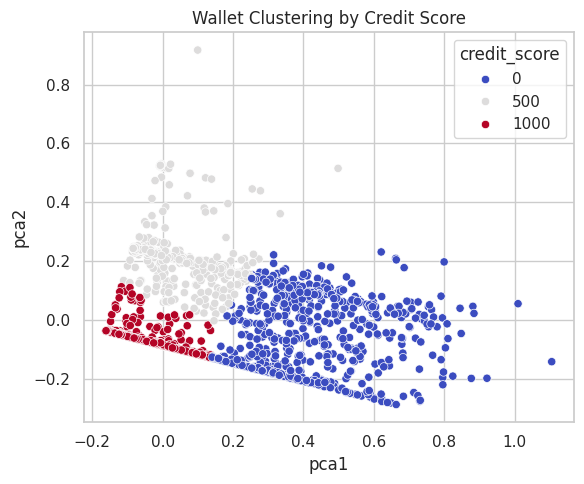

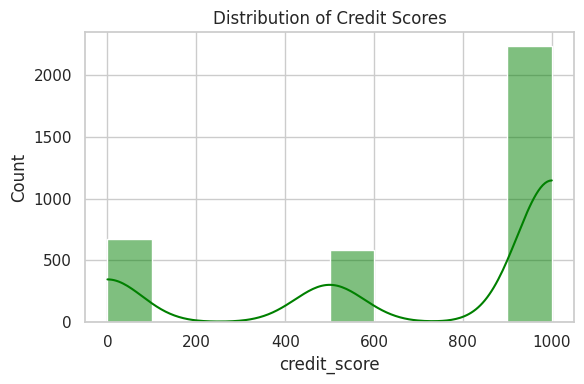

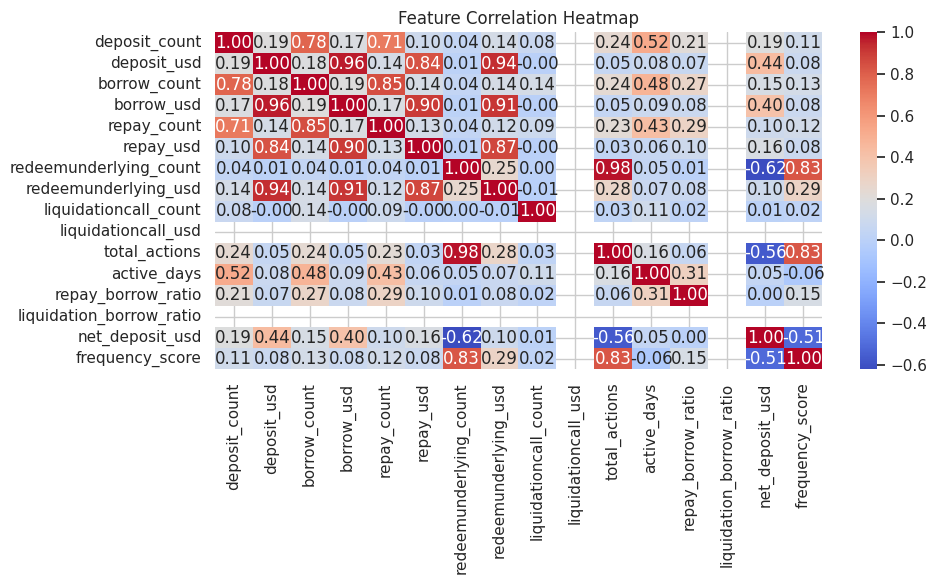

In [27]:


import json
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Step 1: Load and Flatten JSON
# ----------------------------
def load_and_flatten_json(file_path):
    with open("/content/extracted_files/user-wallet-transactions.json", 'r') as f:
        data = json.load(f)

    records = []
    for tx in data:
        ad = tx.get('actionData', {})
        asset = ad.get('assetSymbol', '')
        decimals = 6 if asset == 'USDC' else 18
        amount = float(ad.get('amount', 0)) / (10 ** decimals)
        price = float(ad.get('assetPriceUSD', 0))
        usd_value = amount * price

        records.append({
            'wallet': tx['userWallet'],
            'action': tx['action'],
            'timestamp': datetime.utcfromtimestamp(tx['timestamp']),
            'asset': asset,
            'amount': amount,
            'usd_value': usd_value
        })
    return pd.DataFrame(records)

# ----------------------------
# Step 2: Feature Engineering
# ----------------------------
def engineer_features(df):
    features = []
    grouped = df.groupby('wallet')

    for wallet, group in grouped:
        feat = {'wallet': wallet}
        for action in ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']:
            action_df = group[group['action'] == action]
            feat[f'{action}_count'] = len(action_df)
            feat[f'{action}_usd'] = action_df['usd_value'].sum()

        feat['total_actions'] = len(group)
        feat['active_days'] = (group['timestamp'].max() - group['timestamp'].min()).days + 1
        feat['repay_borrow_ratio'] = (
            feat['repay_usd'] / feat['borrow_usd'] if feat['borrow_usd'] > 0 else 0
        )
        feat['liquidation_borrow_ratio'] = (
            feat['liquidationcall_usd'] / feat['borrow_usd'] if feat['borrow_usd'] > 0 else 0
        )
        feat['net_deposit_usd'] = feat['deposit_usd'] - feat['redeemunderlying_usd']
        feat['frequency_score'] = feat['total_actions'] / feat['active_days']

        features.append(feat)

    return pd.DataFrame(features).fillna(0)

# ----------------------------
# Step 3: Credit Scoring Model
# ----------------------------
def assign_credit_scores(feat_df):
    wallets = feat_df['wallet']
    X = feat_df.drop(columns=['wallet'])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(X_scaled)

    silhouette = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {silhouette:.3f}")

    center_dist = kmeans.cluster_centers_.sum(axis=1)
    rank = np.argsort(center_dist)
    cluster_to_score = {cluster: int(1000 * (1 - i / (len(rank) - 1))) for i, cluster in enumerate(rank)}
    scores = [cluster_to_score[c] for c in clusters]

    return pd.DataFrame({'wallet': wallets, 'credit_score': scores, 'cluster': clusters})

# ----------------------------
# Step 4: Visualization & EDA
# ----------------------------
def visualize_clusters(feat_df):
    X = feat_df.drop(columns=['wallet', 'credit_score', 'cluster'])
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)

    feat_df['pca1'] = pcs[:, 0]
    feat_df['pca2'] = pcs[:, 1]

    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=feat_df, x='pca1', y='pca2', hue='credit_score', palette='coolwarm')
    plt.title('Wallet Clustering by Credit Score')
    plt.tight_layout()
    plt.show()

def plot_eda(merged_df):
    plt.figure(figsize=(6, 4))
    sns.histplot(merged_df['credit_score'], bins=10, kde=True, color='green')
    plt.title("Distribution of Credit Scores")
    plt.tight_layout()
    plt.show()

    corr = merged_df.drop(columns=['wallet', 'credit_score', 'cluster', 'pca1', 'pca2'], errors='ignore').corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

# ----------------------------
# Step 5: Main
# ----------------------------
def main():
    df = load_and_flatten_json('user_wallet_transactions.json')
    feat_df = engineer_features(df)
    credit_scores = assign_credit_scores(feat_df)

    print("Top 10 wallets by credit score:")
    print(credit_scores.sort_values(by='credit_score', ascending=False).head(10))

    merged_df = feat_df.merge(credit_scores, on='wallet')
    visualize_clusters(merged_df)
    plot_eda(merged_df)

if __name__ == '__main__':
    main()

In [28]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os


In [29]:
# ----------------------------
# Step 1: Load and Flatten JSON
# ----------------------------
def load_and_flatten_json(filepath):
    with open("/content/extracted_files/user-wallet-transactions.json", 'r') as f:
        data = json.load(f)
    df = pd.json_normalize(data)
    df['wallet'] = df['userWallet']
    df['amount'] = df['actionData.amount'].astype(float)
    df['price'] = df['actionData.assetPriceUSD'].astype(float)
    df['usd_value'] = df['amount'] * df['price']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df


In [30]:

# ----------------------------
# Step 2: Feature Engineering
# ----------------------------
def engineer_features(df):
    grouped = df.groupby(['wallet', 'action'])['usd_value'].sum().unstack(fill_value=0).reset_index()
    action_counts = df.groupby(['wallet', 'action']).size().unstack(fill_value=0).reset_index()
    total_tx = df.groupby('wallet').size().reset_index(name='total_transactions')

    agg = grouped.merge(action_counts, on='wallet', suffixes=('_usd', '_count'))
    agg = agg.merge(total_tx, on='wallet')

    # Derived features
    agg['net_deposit_usd'] = agg.get('deposit_usd', 0) - agg.get('redeemunderlying_usd', 0)
    agg['repay_borrow_ratio'] = agg.get('repay_usd', 0) / (agg.get('borrow_usd', 1) + 1e-6)
    agg['liquidation_ratio'] = agg.get('liquidationcall_count', 0) / (agg['total_transactions'] + 1e-6)
    agg['frequency_score'] = agg['total_transactions'] / df['timestamp'].dt.year.nunique()

    return agg

In [31]:

# ----------------------------
# Step 3: Clustering and Scoring
# ----------------------------
def assign_credit_scores(df):
    features = ['deposit_usd', 'borrow_usd', 'repay_usd', 'redeemunderlying_usd',
                'net_deposit_usd', 'repay_borrow_ratio', 'liquidation_ratio', 'frequency_score']
    X = df[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_k = 3
    km = KMeans(n_clusters=best_k, random_state=42)
    clusters = km.fit_predict(X_scaled)
    df['cluster'] = clusters

    # Map cluster to credit score range based on cluster center norms
    norms = np.linalg.norm(km.cluster_centers_, axis=1)
    sorted_clusters = np.argsort(norms)
    cluster_to_score = {cluster: i * (1000 // (best_k - 1)) for i, cluster in enumerate(sorted_clusters)}

    df['credit_score'] = df['cluster'].map(cluster_to_score)
    return df[['wallet', 'credit_score', 'cluster']]

In [41]:
# ----------------------------
# Step 4: Visualization
# ----------------------------
def visualize_clusters(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='credit_score_y', palette='coolwarm') # Use credit_score_y
    plt.title('Wallet Clustering by Credit Score')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_eda(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(df['credit_score_y'], bins=10, kde=True) # Use credit_score_y
    plt.title("Credit Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Wallet Count")
    plt.show()

In [42]:
# ----------------------------
# Step 5: Post Analysis (Markdown Output)
# ----------------------------
def generate_analysis_markdown(df, path='analysis.md'):
    score_ranges = pd.cut(df['credit_score_y'], bins=[0,100,200,300,400,500,600,700,800,900,1000]) # Use credit_score_y
    dist = score_ranges.value_counts().sort_index()

    lines = ["# Wallet Credit Score Analysis\n"]
    lines.append("## Score Distribution Ranges\n")
    for r, count in dist.items():
        lines.append(f"- {r}: {count} wallets\n")

    lines.append("\n## Observations\n")
    low_range = df[df['credit_score_y'] <= 200] # Use credit_score_y
    high_range = df[df['credit_score_y'] >= 800] # Use credit_score_y

    lines.append("### Low Score Wallets (0-200):\n")
    lines.append(f"- Avg Liquidation Ratio: {low_range['liquidation_ratio'].mean():.2f}\n")
    lines.append(f"- Avg Repay/Borrow Ratio: {low_range['repay_borrow_ratio'].mean():.2f}\n")

    lines.append("\n### High Score Wallets (800-1000):\n")
    lines.append(f"- Avg Net Deposit: {high_range['net_deposit_usd'].mean():.2f}\n")
    lines.append(f"- Avg Frequency Score: {high_range['frequency_score'].mean():.2f}\n")

    with open(path, 'w') as f:
        f.writelines(lines)

    print(f"\n analysis.md generated at: {os.path.abspath(path)}")


 Top 10 wallets by credit score:
                                          wallet  credit_score  cluster
54    0x000f7f22bfc28d940d4b68e13213ab17cf107790          1000        2
137   0x0034baeeb160a5f1032b6d124d3e87cc94d74e62          1000        2
1299  0x022b3fa410364e1e28054b704b0da3b67aa6dc90          1000        2
1733  0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6           500        1
3178  0x058b10cbe1872ad139b00326686ee8ccef274c58           500        1
2333  0x0400fa459b58b8c1d14e091548d6f2134b12149e             0        0
2332  0x04008507db2ab8b2bf5410905d4b146ea8009c2f             0        0
2331  0x04007f94d19462042fd84e93fcec9a5b05cf5db6             0        0
2330  0x04002cbd1cc19cb7cb1f819fc7ef410b59f8a22d             0        0
2334  0x04017f70e7299e9cbe9355780b0f7a261eccb163             0        0

Columns in merged_df before visualization:
Index(['wallet', 'borrow_usd', 'deposit_usd', 'liquidationcall_usd',
       'redeemunderlying_usd', 'repay_usd', 'borrow_count', '

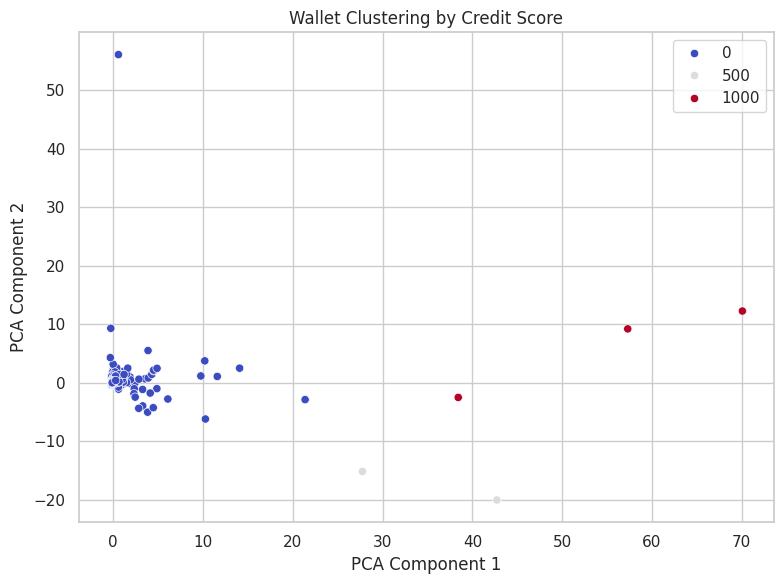

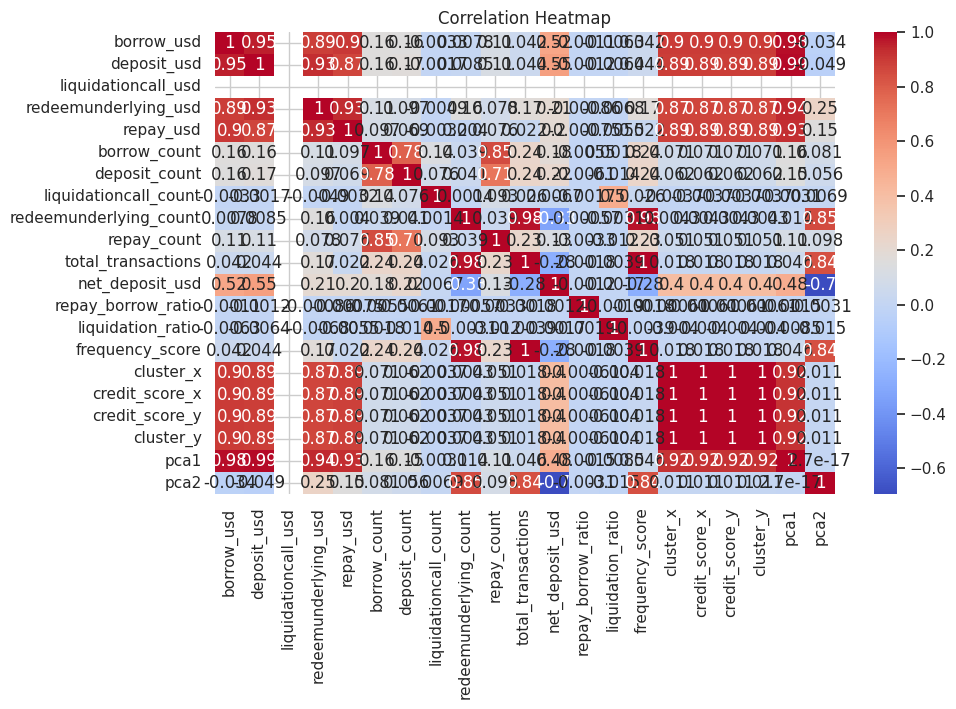

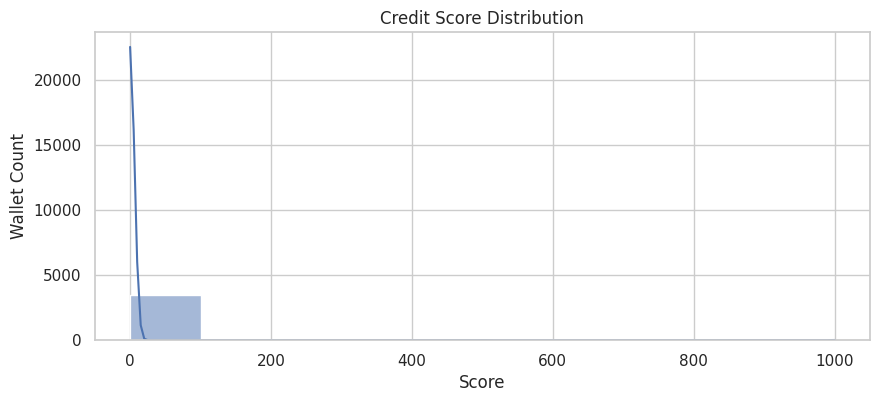


 analysis.md generated at: /content/analysis.md


In [43]:
# ----------------------------
# Step 6: Main
# ----------------------------
def main():
    df = load_and_flatten_json('user_wallet_transactions.json')
    feat_df = engineer_features(df)
    scores = assign_credit_scores(feat_df)

    print("\n Top 10 wallets by credit score:")
    print(scores.sort_values(by='credit_score', ascending=False).head(10))

    merged_df = feat_df.merge(scores, on='wallet')

    # Calculate PCA components and add them to merged_df
    features = ['deposit_usd', 'borrow_usd', 'repay_usd', 'redeemunderlying_usd',
                'net_deposit_usd', 'repay_borrow_ratio', 'liquidation_ratio', 'frequency_score']
    X = merged_df[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)
    merged_df['pca1'] = pcs[:, 0]
    merged_df['pca2'] = pcs[:, 1]

    # Debugging: Print columns before visualization
    print("\nColumns in merged_df before visualization:")
    print(merged_df.columns)

    visualize_clusters(merged_df)
    plot_eda(merged_df)
    generate_analysis_markdown(merged_df)

if __name__ == '__main__':
    main()